In [18]:
#!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

# 画图工具
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.models import Sequential

from keras.models import Model, load_model
from keras.utils import layer_utils
from keras.utils import np_utils

from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop,Adam,SGD
from keras.callbacks import Callback, EarlyStopping, TensorBoard

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.applications.resnet50 import ResNet50

from keras import backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


### 下载数据集
下载数据压缩包，解压，然后清理压缩包。

In [2]:
from modelarts.session import Session
session = Session()

if not os.path.exists('./data'):
    session.download_data(
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz",
    path="./image_recognition.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./image_recognition.tar.gz

    # 清理压缩包
    !rm -f ./image_recognition.tar.gz

In [3]:
#!ls -al ./data 

In [4]:
DATA_DIR = './data/' # 数据集路径

ROWS = 224
COLS = 224
CHANNELS = 3

In [5]:
image_file_names = [DATA_DIR+i for i in os.listdir(DATA_DIR)] 

In [6]:
image_file_names[:10]

['./data/dog.12464.jpg',
 './data/cat.5826.jpg',
 './data/cat.12108.jpg',
 './data/dog.8754.jpg',
 './data/cat.4329.jpg',
 './data/dog.4741.jpg',
 './data/cat.10673.jpg',
 './data/dog.3754.jpg',
 './data/dog.1481.jpg',
 './data/cat.9792.jpg']

In [7]:
dogs = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]

In [8]:
dogs[:10]

['./data/dog.12464.jpg',
 './data/dog.8754.jpg',
 './data/dog.4741.jpg',
 './data/dog.3754.jpg',
 './data/dog.1481.jpg',
 './data/dog.2764.jpg',
 './data/dog.10477.jpg',
 './data/dog.6095.jpg',
 './data/dog.11514.jpg',
 './data/dog.5191.jpg']

In [9]:
cats = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]

In [10]:
cats[:10]

['./data/cat.5826.jpg',
 './data/cat.12108.jpg',
 './data/cat.4329.jpg',
 './data/cat.10673.jpg',
 './data/cat.9792.jpg',
 './data/cat.11838.jpg',
 './data/cat.5299.jpg',
 './data/cat.5500.jpg',
 './data/cat.4752.jpg',
 './data/cat.3744.jpg']

In [11]:
# 数据洗牌
random.shuffle(image_file_names)
#shuffle() 方法将序列的所有元素随机排序。

In [12]:
#print(image_file_names)

使用函数cv2.imread()读取图片。第一个参数是文件路径；第二个参数指定以什么方式读取：

cv2.IMREAD_COLOR：加载彩色图片，这个是默认参数。
cv2.IMREAD_GRAYSCALE：以灰度模式加载图片。
cv2.IMREAD_UNCHANGED：包括alpha。

上面三个flag分别对应的值为1，0，-1。

缩放变换即改变图片大小，在cv2里面我们使用函数cv2.resize（fileobj, None,(fx, fy), interpolation = format）函数。“fileobj”为图片对象；“（fx, fy）”参数类型为tuple， 可以指定大小如“（640， 480）”，也可以“fx=640，fy=480”；“interpolation”为插补项，可以选择cv2.INTER_AREA（使用象素关系重采样）、cv2.INTER_LINEAR（双线性插值）、cv2.INTER_CUBIC（立方插值）等变换方法，cv2.INTER_AREA适合缩小使用，cv2.INTER_LINEAR、cv2.INTER_CUBIC（慢）适合放大使用。

In [13]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) # 彩色模式读取图像
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(image_file_names):
    count = len(image_file_names)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    #data.shape    (25000, 128, 128, 3)
    
    
    for i, image_file in enumerate(image_file_names):
        image = read_image(image_file)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [14]:
# 读取图片至内存
images = prep_data(image_file_names)

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000


### 给图片打标签¶
我们根据图片名称包含的字符串给图片打标签。我们用0表示cat，1表示dog。

In [15]:
num_train_samples = len(image_file_names)  #25000

In [16]:
num_classes = 2
labels = []

In [17]:
index = 0
for filename in image_file_names:
    if 'dog' in filename:
        labels.append(1)
    elif 'cat' in filename:
        labels.append(0)
        
# 把类别标签转换为onehot编码
labels = np_utils.to_categorical(labels, num_classes)

In [18]:
print(labels[:3])

[[1. 0.]
 [1. 0.]
 [0. 1.]]


### 切分数据集
（train_data，train_label）是训练数据，（test_data，test_label）是测试数据。测试数据占25%。

In [19]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.25, random_state=10)

### 查看猫狗的样本图片
这些图片是经过尺寸调整后的图片

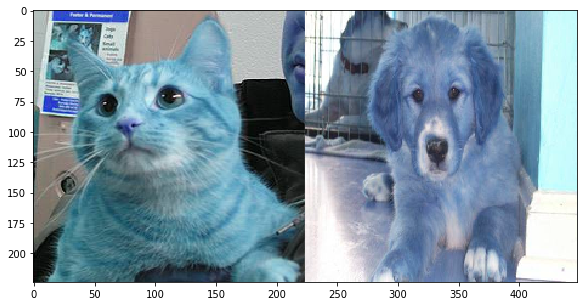

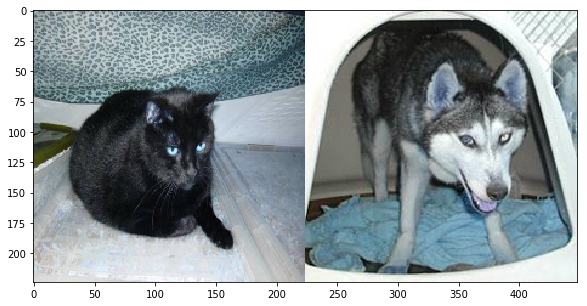

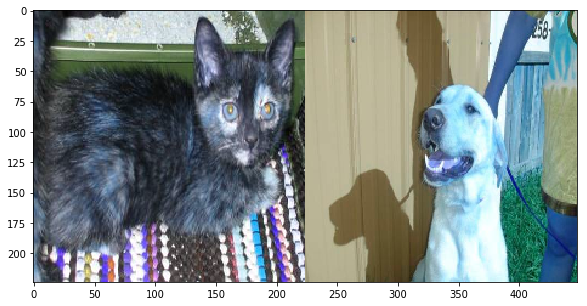

In [20]:
def show_cats_and_dogs(idx):
    cat = read_image(cats[idx])
    dog = read_image(dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,3):
    show_cats_and_dogs(idx)

### Keras 的应用模块（keras.applications）提供的可用模型
在 ImageNet 上预训练过的用于图像分类的模型：
Xception、VGG16、VGG19、ResNet50、InceptionV3、InceptionResNetV2、MobileNet、DenseNet、NASNet、MobileNetV2
所有的这些架构都兼容所有的后端 (TensorFlow, Theano 和 CNTK)，并且会在实例化时，根据 Keras 配置文件〜/.keras/keras.json 中设置的图像数据格式构建模型。

如本例中，我们设置 image_data_format=channels_last，则加载的模型将按照 TensorFlow 的维度顺序来构造，即「高度-宽度-深度」（Height-Width-Depth）的顺序。

In [21]:
!cat ~/.keras/keras.json

{
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_last"
}

### 6、构建ResNet50网络(下载模型会比较慢，网速好的情况会很快)¶

In [22]:
#初始化ResNet50基准模型
#这部分是核心工作，目的是使用ImageNet训练出的权重来做我们的特征提取器，注意这里后面的分类层去掉

base_model = ResNet50(weights="imagenet", include_top=False, pooling=None, input_shape=(ROWS, COLS, CHANNELS), classes=2)

#返回 一个 Keras Model 对象。
#参数说明如下：
# weights: None 代表随机初始化， 'imagenet' 代表加载在 ImageNet 上预训练的权值。
# include_top: 是否包括顶层的全连接层。 这里为False，因为原模型有1000个类别而我们只有猫、狗2个类别，所以需要去掉然后自己搭建最终的全连接层。
# pooling: 可选，当 include_top 为 False 时，该参数指定了特征提取时的池化方式。
#                               为 None 代表不池化，直接输出最后一层卷积层的输出，该输出是一个四维张量。
#                               'avg' 代表全局平均池化（GlobalAveragePooling2D），相当于在最后一层卷积层后面再加一层全局平均池化层，输出是一个二维张量。
#                               'max' 代表全局最大池化
#input_shape: 可选，输入尺寸元组，仅当 include_top=False 时有效，否则输入形状必须是 (244, 244, 3)（对于 channels_last 数据格式），
#             或者 (3, 244, 244)（对于 channels_first 数据格式）。它必须拥有 3 个输入通道，且宽高必须不小于 32。
#             例如 (200, 200, 3) 是一个合法的输入尺寸。
#classes:     可选，图片分类的类别数，仅当 include_top 为 True 并且不加载预训练权值时可用。
#-----------------------------------------------------------------------------------------------------------------

# 因为是训练好的，所以我们冻结base_model所有层，这样就可以正确获得bottleneck特征
for layer in base_model.layers:
    layer.trainable = False

#猫狗分类部分，需要我们根据现有需求来新定义，
x = base_model.output
#添加自己的全链接分类层
# Dense就是常用的全连接层，所实现的运算是output = activation(dot(input, kernel)+bias)。其中activation是逐元素计算的激活函数，
#kernel是本层的权值矩阵，bias为偏置向量，只有当use_bias=True才会添加。
#如果本层的输入数据的维度大于2，则会先被压为与kernel相匹配的大小。

x = Flatten()(x)     #Flatten层用来将输入“压平”，即把多维的输入一维化，常用在从卷积层到全连接层的过渡。Flatten不影响batch的大小。
x = Dense(1024, activation='relu')(x)  
#units：大于0的整数，代表该层的输出维度。这里为1024；
#activation：激活函数，为预定义的激活函数名，如果不指定该参数，将不会使用任何激活函数（即使用线性激活函数：a(x)=x），这里使用relu激活函数
x = Dropout(0.5)(x)
#为输入数据施加Dropout。Dropout将在训练过程中每次更新参数时按一定概率（rate）随机断开输入神经元，Dropout层用于防止过拟合。
predictions = Dense(2, activation='softmax')(x)

94658560/94653016 [==============================] - 226s 2us/step


#### Keras 的应用模块提供了带有预训练权值的深度学习模型，这些模型可以用来进行预测、特征提取和微调（fine-tuning）。
当初始化一个预训练模型时，会自动下载权重到 ~/.keras/models/ 目录下

In [23]:
!ls -al ~/.keras/models/

total 92436
drwxr-s--- 2 jovyan users       65 Jul 13 16:14 .
drwxr-s--- 3 jovyan users       36 Jul 13 16:14 ..
-rw-r----- 1 jovyan users 94653016 Jul 13 16:18 resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [24]:
#!cp ~/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 ./
#!ls -al

In [25]:
#训练模型
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [27]:
# 构建神经网络
optimizer  = SGD(lr=1e-4,decay=1e-6,momentum=0.9,nesterov=True)
#optimizer = Adam(lr=1e-4) # 优化器使用RMSprop, 设置学习率是1e-4
#optimizer = RMSprop(lr=0.0003) 
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
#训练相关参数
epochs = 30 # 训练轮数
batch_size = 16 # 批大小

# Loss记录
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# early stopping策略
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')   

def run_catdog():
    history = LossHistory()
    
    # 开始训练
    model.fit(
        train_data, 
        train_label, 
        batch_size=batch_size, 
        epochs=epochs,
        validation_split=0.25,  # 训练数据中，抽取25%的数据作为验证数据
        verbose=2,
        shuffle=True,
        callbacks=[history, early_stopping]) 
    
    return  history

In [29]:
#开始训练
history = run_catdog()

Train on 14062 samples, validate on 4688 samples
Epoch 1/30
 - 74s - loss: 0.1809 - acc: 0.9509 - val_loss: 0.1087 - val_acc: 0.9744
Epoch 2/30
 - 61s - loss: 0.0553 - acc: 0.9814 - val_loss: 0.0841 - val_acc: 0.9770
Epoch 3/30
 - 62s - loss: 0.0301 - acc: 0.9898 - val_loss: 0.0973 - val_acc: 0.9729
Epoch 4/30
 - 61s - loss: 0.0205 - acc: 0.9934 - val_loss: 0.1236 - val_acc: 0.9712
Epoch 5/30
 - 62s - loss: 0.0181 - acc: 0.9937 - val_loss: 0.0814 - val_acc: 0.9787
Epoch 6/30
 - 61s - loss: 0.0169 - acc: 0.9933 - val_loss: 0.0937 - val_acc: 0.9742
Epoch 7/30
 - 62s - loss: 0.0125 - acc: 0.9953 - val_loss: 0.1220 - val_acc: 0.9712
Epoch 8/30
 - 61s - loss: 0.0103 - acc: 0.9963 - val_loss: 0.1085 - val_acc: 0.9742
Epoch 9/30
 - 62s - loss: 0.0102 - acc: 0.9964 - val_loss: 0.1240 - val_acc: 0.9708
Epoch 10/30
 - 61s - loss: 0.0077 - acc: 0.9973 - val_loss: 0.1327 - val_acc: 0.9703
Epoch 00010: early stopping


In [30]:
# 训练好的模型可以保存起来，永久使用
OUTPUT = 'output'
if not os.path.exists(OUTPUT):
    os.mkdir(OUTPUT)
model.save(os.path.join(OUTPUT, 'model.resnet50.h5'))

### 可视化训练过程
将Loss随epoch的变化趋势使用折线图展示

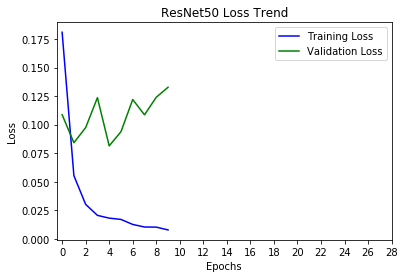

In [31]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet50 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

将accurary随epoch的变化趋势使用折线图展示

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.xlabel('Epochs')
plt.ylabel('acc')
plt.title('VGG-16 acc Trend')
plt.plot(acc, 'blue', label='Training acc')
plt.plot(val_acc, 'green', label='Validation acc')
plt.xticks(range(0, epochs)[0::2])
plt.legend()
plt.show()

### 采用模型预测

[9.9981517e-01 1.8488819e-04]
I am 99.98% sure this is a Cat


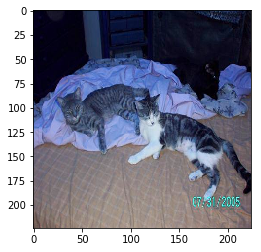

In [33]:
# 预测测试集
predictions = model.predict(test_data, verbose=0)   
for i in range(0,1):
    if predictions[i, 0] >= 0.5:         
        print(predictions[i, :])
        print('I am {:.2%} sure this is a Cat'.format(predictions[i][0]))
    else: 
        print(predictions[i, :])
        print('I am {:.2%} sure this is a Dog'.format(1 - predictions[i][0]))        
    plt.imshow(test_data[i])
    plt.show()

[9.9981517e-01 1.8488819e-04]
I am 99.98% sure this is a Cat


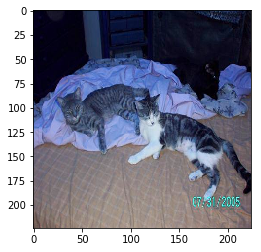

[1.0000000e+00 1.4336182e-14]
I am 100.00% sure this is a Cat


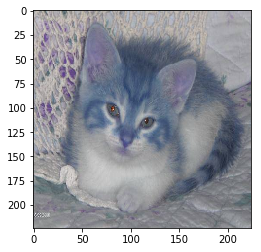

[2.5318322e-12 1.0000000e+00]
I am 100.00% sure this is a Dog


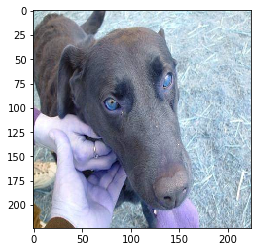

[1.0000000e+00 1.1398401e-11]
I am 100.00% sure this is a Cat


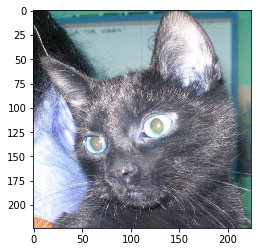

[1.9066533e-07 9.9999976e-01]
I am 100.00% sure this is a Dog


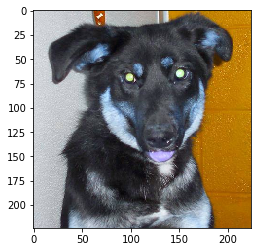

[7.5967235e-16 1.0000000e+00]
I am 100.00% sure this is a Dog


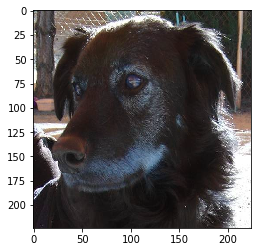

[2.831987e-09 1.000000e+00]
I am 100.00% sure this is a Dog


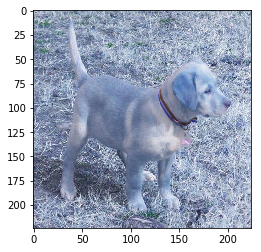

[1.0000000e+00 1.3349219e-13]
I am 100.00% sure this is a Cat


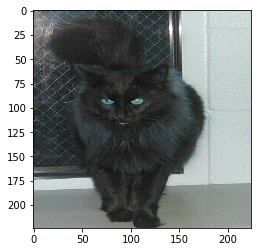

[1.0000000e+00 3.3143794e-12]
I am 100.00% sure this is a Cat


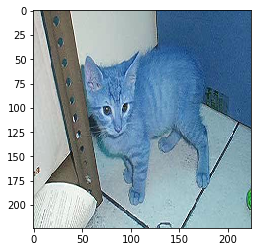

[1.000000e+00 4.749687e-15]
I am 100.00% sure this is a Cat


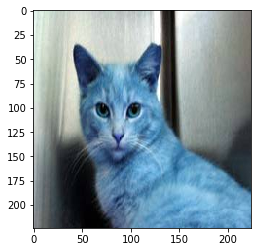

In [34]:
for i in range(0,10):
    p = predictions[i]
    print(p)
    if round(p[1]) == 1: 
        print('I am {:.2%} sure this is a Dog'.format(p[1]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1 - p[1]))
        
    plt.imshow(test_data[i])
    plt.show()

### 测试集预测结果

In [36]:
# 预测测试集
# predictions = model.predict(test_data, verbose=0)
# 评估模型准确度
predictions_test = []
test_label_test = []
for p in predictions:

    if int(round(p[0])) == 1:
        predictions_test.append(1)
    else:
        predictions_test.append(0)

#print predictions_test

for t in test_label:
    if int(t[0]) == 1:
        test_label_test.append(1)
    else:
        test_label_test.append(0)
acc = accuracy_score(test_label_test, predictions_test)

print('训练得到的猫狗识别模型的准确度是：%f' % acc)

训练得到的猫狗识别模型的准确度是：0.968480


In [ ]:
!ls -al 